In [3]:
using Pkg
venv_dir = (@__DIR__) * "../../muc_venv/"
Pkg.activate(venv_dir)

import PhysicalConstants.CODATA2018: G
using NaturallyUnitful
using DifferentialEquations
using Roots
using QuadGK
using PythonPlot
using LaTeXStrings
import SpecialFunctions: besselk

import DelimitedFiles: writedlm, readdlm

figdir = "./"

golden_ratio = (1+sqrt(5))/2

const lifetime_conv = ustrip(unnatural(u"s", 1*u"GeV^-1"))

rc("font", family="serif", serif="Computer Modern", size=14)
rc("figure", autolayout=true)
rc("axes", labelsize=16, unicode_minus=false)
rc("text", usetex=true)
rc("text.latex", preamble=raw"\usepackage{slashed}")
;

  Activating project at `~/Library/CloudStorage/Dropbox/research/muon-collider/flavored-dm/flavored-dm/Sam/relic_abundance/muc_venv`


In [4]:
include(venv_dir*"boltz_utils.jl")
using .utils

#include(venv_dir*"hubble.jl")
#using .Hubble
include(venv_dir*"gstar.jl")
using .gstar

include((@__DIR__)*"/cross_sections.jl")
using .uRFlavorDM

#### Define Cross-Sections and Differential Equations

In [5]:
function pi2σ_φφ_to_f(α, model::uRFDM)
    pi2σ_φφ_to_γγ(α, model) + 
    pi2σ_φφ_to_γZ(α, model) + 
    pi2σ_φφ_to_ZZ(α, model) + 
    pi2σ_φφ_to_WW(α, model) + 
    pi2σ_φφ_to_gg(α, model) + 
    pi2σ_φφ_to_gγ(α, model) + 
    pi2σ_φφ_to_gZ(α, model) + 
    3*pi2σ_φφ_to_ll(α, model) + 
    6*pi2σ_φφ_to_qq(α, model)
end

function lifetime_φ(λ, mφ, mχ)
    mm = uRFDM(λ, mφ, mχ)
    decay = 3*Γ_φ_to_χq(mm)
    return lifetime_conv / decay
end
;

In [6]:
[ 1/x^2*pi2σ_φφ_to_f(25., uRFDM(1e-12, x, 1e-4)) for x in [1000., 2000., 3000.] ]

3-element Vector{Float64}:
 5.603149888548265e-8
 1.4007849759724775e-8
 6.2257089511942475e-9

In [7]:
function diffeq(du, u, p, x)
    yeq_φ = Y_eq(x, p.gφ)
    yeq_rat = Y_eq_ratio(x, p)

    decay = 3*C12(Γ_φ_to_χq, x, p.mφ; args=(p,))*(exp(-u[1]) - u[2]*yeq_rat)

    # u[1] tracks the abundance of a *single* color of φ;
    du[1] = exp(u[1])*(C22(pi2σ_φφ_to_f, x, p.mφ, p.gφ; args=(p,))*(exp(-2*u[1])-yeq_φ^2) + decay)
    
    # factor of 3 for 3 colors of φ that decay to χ
    du[2] = 3 * decay
end
;

In [8]:
# Model-dependent Boltzmann equation stuff:
function bk2_ratio(x, δ)
    if x < 1e-2
        return δ^2*(1-(1-δ^2)*x^2/4)
    elseif x < 1e2/δ
        return besselk(2,x)/besselk(2,δ*x)
    else
        return exp(-(1-δ)*x)*(sqrt(δ)-15*(1-δ)/(8*x*sqrt(δ)))
    end
end

function Y_eq_ratio(x, model::uRFDM)
    (model.gφ/model.gχ)*(model.mφ/model.mχ)^2*bk2_ratio(x, model.mχ/model.mφ)
end

# the Boltzmann equation for just φ, assuming no decays to χ:
function f_φ(y, p, x)
    yeq_φ = Y_eq(x, p.gφ)
    exp(y)*C22(pi2σ_φφ_to_f, x, p.mφ, p.gφ; args=(p,))*(exp(-2*y)-yeq_φ^2)
end

# the Boltzmann equation for just χ, assuming φ remains in equilibrium
function f_χ(y, p, x)
    yeq_χ = Y_eq(x*p.mχ/p.mφ, p.gχ)
    yeq_rat = Y_eq_ratio(x, p)
    # one factor of 3 for flavors, one factor of 3 for three colors of φ in equilibrium
    return 3*3*yeq_rat*C12(Γ_φ_to_χq, x, p)*(yeq_χ-y)
end
;

In [9]:
function solve_boltz(λ, mφ, mχ; xspan=(1e-4, 1e8))
    mm = uRFDM(λ, mφ, mχ)

    # y0 = [Y_eq(xspan[1], mm.gφ), 0.0 ]
    z0 = [z_eq(xspan[1], mm.gφ), 0.0]

    prob = ODEProblem(diffeq, z0, xspan, mm)
    sol = solve(prob, Rodas4P(); reltol=1e-8, verbose=false)

    return sol
end


function find_yφfo(mφ; xspan=(1e-4, 1e8))
    mm = uRFDM(0.0, mφ, 0.0)

    #z0 = [z_eq(xspan[1], mm.gφ), z_eq(xspan[1], mm.gφ)]
    z0 = -log(Y_eq(xspan[1], mm.gφ))

    prob = ODEProblem(f_φ, z0, xspan, mm)
    sol = solve(prob, Rodas4P(); reltol=1e-8, verbose=false)

    return exp.(-sol(xspan[2]))
end

function yχf_I(mφ)
    quadgk(x -> x^3*besselk(1,x)/sqrt(gstar_interp(mφ/x)), 0, Inf)[1]
end

"""
    find_yχf(λ, mφ, mχ; gφ=1)

Calculates the final χ yield, assuming φ remains in equilibrium
"""

function find_yχfi(λ, mφ, mχ; gφ=1)
    mm = uRFDM(λ, mφ, gφ, mχ, 2)
    I = yχf_I(mφ)
    
    # one factor of 3 for flavors, one factor of 3 for three colors of φ in equilibrium
    return 3 * I * gφ*3*Γ_φ_to_χq(mm) / (2*π^2*mφ^2*utils.h_consts)
end

"""
    find_yχf(I, λ, mφ, mχ; gφ=1)

When called with the result of the integral as the first argument, skips
re-calculating the integral (useful because the integral only depends on mφ)
"""
function find_yχfi(I, λ, mφ, mχ; gφ=1)
    mm = uRFDM(λ, mφ, gφ, mχ, 2)

    # one factor of 3 for flavors, one factor of 3 for three colors of φ in equilibrium
    return 3 * I * gφ*3*Γ_φ_to_χq(mm) / (2*π^2*mφ^2*utils.h_consts)
end

function find_yχf_full(λ, mφ, mχ; xspan=(1e-4, 1e8))
    mm = uRFDM(λ, mφ, mχ)

    # y0 = [Y_eq(xspan[1], mm.gφ), 0.0]
    z0 = [z_eq(xspan[1], mm.gφ), z_eq(xspan[1], mm.gφ), 0.0]

    prob = ODEProblem(diffeq, z0, xspan, mm)
    sol = solve(prob, Rodas4P(); reltol=1e-8, verbose=false)

    return sol(xspan[2])[3]
end

# factor of 3 due to the different colors of φ
function find_mχ_max()
    find_zero(x -> utils.Mstar_s(x/25) - 3*x*sum(find_yφfo(x)), (1e3, 1e4))
end

# factor of 3 due to the different colors of φ
# mχ_max default value set to output of find_mχ_max()
function mχ_upper_bound(mφ; mχ_max=6659.4173934393375)
    if mφ > mχ_max
        return Mstar_s(mφ/25)/(3*sum(find_yφfo(mφ)))
    else
        return mφ
    end
end
;

In [9]:
find_mχ_max()

6659.4173934393375

In [10]:
λ = 1e-12
mφ = 1e3 # GeV
mχ = 1e-2 # GeV

sol = solve_boltz(λ, mφ, mχ);
yφfo = find_yφfo(mφ);
yχfi = find_yχfi(λ, mφ, mχ);

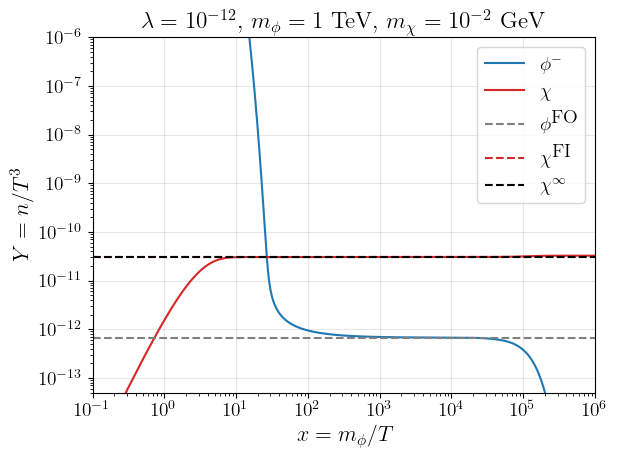

In [11]:
xs = 10 .^ range(-4, 8, 1000)
s = sol(xs)
Y_phim = exp.(-s[1,:])
#Y_phi0 = exp.(-s[2,:])
Y_chi = s[2,:]

fig = figure()

plot(xs, Y_phim, label=L"$\phi^-$", c="tab:blue")
plot(xs, Y_chi, label=L"$\chi$", c="tab:red")

axhline(yφfo, c="grey", ls="dashed", label=L"\phi^{\textrm{FO}}")
axhline(yχfi, c="tab:red", ls="dashed", label=L"\chi^{\textrm{FI}}")
axhline(yχfi+yφfo, c="black", ls="dashed", label=L"\chi^{\infty}")

xlim(1e-1, 1e6)
ylim(5e-14, 1e-6)
#xlim(1e0,1e6)
#ylim(1e-11,1e-10)

xscale("log")
yscale("log")

grid(alpha=0.3)

legend()

xlabel(L"x = m_\phi/T")
ylabel(L"Y = n/T^3")
title(L"$\lambda = 10^{-12}$, $m_\phi = 1$ TeV, $m_\chi = 10^{-2}$ GeV")

plotclose()
# fig.savefig("boltz_LL.pdf")
fig

Compute the coupling that gives the correct relic abundance:

In [ ]:
function find_λ(mφ, mχ)
    # factor of 3 for the different colors of φ
    yφfo = 3*sum(find_yφfo(mφ))
    yχfi = find_yχfi(1.0, mφ, mχ)

    return sqrt( (Mstar_s(mφ/25)/mχ - yφfo) / yχfi )
end

function find_λs(Mφ, Mχ)
    result = zeros(Float64, (length(Mφ), length(Mχ)))
    Threads.@threads for i in eachindex(Mφ)
        # factor of 3 for the different colors of φ
        yφfo = 3*sum(find_yφfo(Mφ[i]))
        yχI = yχf_I(Mφ[i])

        for j in eachindex(Mχ)
            if (Mχ[j] < Mstar_s(Mφ[i]/25)/yφfo) & (Mχ[j] < Mφ[i]) 
                yχfi = find_yχfi(yχI, 1.0, Mφ[i], Mχ[j])
                result[i,j] = sqrt( (Mstar_s(Mφ[i]/25)/Mχ[j] - yφfo) / yχfi )
            else
                result[i,j] = NaN
            end
        end
    end
    return result
end
;

In [48]:
find_yχfi(1.0, mφ, mχ)

3.0457733317196734e13

Setup Grids for Exporting to MadGraph

In [13]:
mphis = vcat(100.0:25.0:350.0, 400.0:50.0:800.0, 900.0:100.0:1600.0, 1800.0:200.0:5000.0)
mchis = 10 .^ range(-5.0, 4.0, 100)
lambdas = find_λs(mphis, mchis)

writedlm("uR_lambdas_grid.csv", lambdas)
writedlm("mphis_grid.csv", mphis)
writedlm("mchis_grid.csv", mchis)


In [10]:
mphis = readdlm("mphis_grid.csv")
mchis = readdlm("mchis_grid.csv")
lambdas = readdlm("uR_lambdas_grid.csv")

45×100 Matrix{Float64}:
 4.89026e-9  4.4043e-9   3.96664e-9  …  NaN            NaN  NaN  NaN  NaN
 5.56948e-9  5.01603e-9  4.51758e-9     NaN            NaN  NaN  NaN  NaN
 6.19605e-9  5.58033e-9  5.0258e-9      NaN            NaN  NaN  NaN  NaN
 6.76237e-9  6.09038e-9  5.48517e-9     NaN            NaN  NaN  NaN  NaN
 7.27801e-9  6.55478e-9  5.90342e-9     NaN            NaN  NaN  NaN  NaN
 7.75313e-9  6.98269e-9  6.28881e-9  …  NaN            NaN  NaN  NaN  NaN
 8.20334e-9  7.38816e-9  6.65398e-9     NaN            NaN  NaN  NaN  NaN
 8.62697e-9  7.76969e-9  6.9976e-9      NaN            NaN  NaN  NaN  NaN
 9.02878e-9  8.13158e-9  7.32352e-9     NaN            NaN  NaN  NaN  NaN
 9.41431e-9  8.47879e-9  7.63624e-9     NaN            NaN  NaN  NaN  NaN
 ⋮                                   ⋱    ⋮                           
 3.07986e-8  2.77381e-8  2.49817e-8     NaN            NaN  NaN  NaN  NaN
 3.16915e-8  2.85422e-8  2.57059e-8     NaN            NaN  NaN  NaN  NaN
 3.25599e-8  2.93

In [15]:
models = uRFDM.(lambdas, mphis, mchis')
phi_totwidth = 3*Γ_φ_to_χq.(models)
phi_to_qchi = Γ_φ_to_χq.(models)
phi_BR_qchi = phi_to_qchi ./ phi_totwidth
phi_lifetimes = lifetime_φ.(lambdas, mphis, mchis');

writedlm("uR_phi_totwidth_GeV.csv", phi_totwidth)
writedlm("phi_BR_qchi.csv", phi_BR_qchi)
writedlm("phi_lifetimes_sec.csv", phi_lifetimes)

In [11]:
phi_totwidth = readdlm("uR_phi_totwidth_GeV.csv")
phi_BR_qchi = readdlm("phi_BR_qchi.csv")
phi_lifetimes = readdlm("phi_lifetimes_sec.csv")

45×100 Matrix{Float64}:
 4.61159e-9   5.68538e-9   7.0092e-9    …  NaN           NaN  NaN  NaN  NaN
 2.8443e-9    3.50658e-9   4.32308e-9      NaN           NaN  NaN  NaN  NaN
 1.91511e-9   2.36104e-9   2.9108e-9       NaN           NaN  NaN  NaN  NaN
 1.37809e-9   1.69898e-9   2.09458e-9      NaN           NaN  NaN  NaN  NaN
 1.04102e-9   1.28342e-9   1.58226e-9      NaN           NaN  NaN  NaN  NaN
 8.15413e-10  1.00528e-9   1.23935e-9   …  NaN           NaN  NaN  NaN  NaN
 6.5553e-10   8.08168e-10  9.96348e-10     NaN           NaN  NaN  NaN  NaN
 5.38846e-10  6.64315e-10  8.18998e-10     NaN           NaN  NaN  NaN  NaN
 4.50957e-10  5.5596e-10   6.85414e-10     NaN           NaN  NaN  NaN  NaN
 3.82872e-10  4.72023e-10  5.81931e-10     NaN           NaN  NaN  NaN  NaN
 ⋮                                      ⋱    ⋮                          
 3.41959e-12  4.21583e-12  5.19747e-12     NaN           NaN  NaN  NaN  NaN
 3.05019e-12  3.76042e-12  4.63602e-12     NaN           NaN  NaN  

In [17]:
mphi_for_bound = 10 .^ range(2, 5, 100)
mχ_upper = mχ_upper_bound.(mphi_for_bound)

writedlm("mchi_upper.csv",mχ_upper)

In [12]:
mphi_for_bound = 10 .^ range(2, 5, 100)
mχ_upper = readdlm("mchi_upper.csv")[:,1]

100-element Vector{Float64}:
 100.0
 107.22672220103232
 114.97569953977356
 123.28467394420659
 132.19411484660287
 141.74741629268047
 151.99110829529332
 162.97508346206433
 174.7528400007683
 187.3817422860385
   ⋮
 840.8784330775752
 786.4388359856148
 735.5306774652656
 687.924761085624
 643.4063794168862
 601.774648774915
 562.8424785338102
 526.4338426993795
 492.38515456683035

## Plots

In [ ]:
# finer grid of mphi, mchi for the plots
mphis_for_plots = 10 .^ range(2, 5, 500)
mchis_for_plots = 10 .^ range(-5, 5, 500)
lambdas_for_plots = find_λs(mphis_for_plots, mchis_for_plots)

writedlm("uR_lambdas_for_plot_grid.csv", lambdas_for_plots)
writedlm("mphis_for_plot_grid.csv", mphis_for_plots)
writedlm("mchis_for_plot_grid.csv", mchis_for_plots)
;

In [119]:

mphis_for_plots = readdlm("mphis_for_plot_grid.csv")[:,1]
mchis_for_plots = readdlm("mchis_for_plot_grid.csv")[:,1]

lambdas_for_plots = readdlm("uR_lambdas_for_plot_grid.csv")
#lambda_min = minimum(lambdas_for_plots[map(!,isnan.(lambdas_for_plots))])
#lambdas_for_plots[isnan.(lambdas_for_plots)] .= lambda_min
;

In [ ]:
models = uRFDM.(lambdas_for_plots, mphis_for_plots, mchis_for_plots')
phi_totwidth = 3*Γ_φ_to_χq.(models)
phi_to_qchi = Γ_φ_to_χq.(models)
phi_BR_qchi = phi_to_qchi ./ phi_totwidth
phi_lifetimes = lifetime_φ.(lambdas_for_plots, mphis_for_plots, mchis_for_plots');
writedlm("phi_lifetimes_for_plot.csv", phi_lifetimes)

In [89]:
phi_lifetimes = readdlm("phi_lifetimes_for_plot.csv");

In [135]:
lam2 = zeros(Float64, size(lambdas_for_plots))
for i in eachindex(mphis_for_plots)
for j in eachindex(mchis_for_plots)
if 2*mchis_for_plots[j] > mphis_for_plots[i]
lam2[i,j] = NaN
else
lam2[i,j] = lambdas_for_plots[i,j]
end
end
end

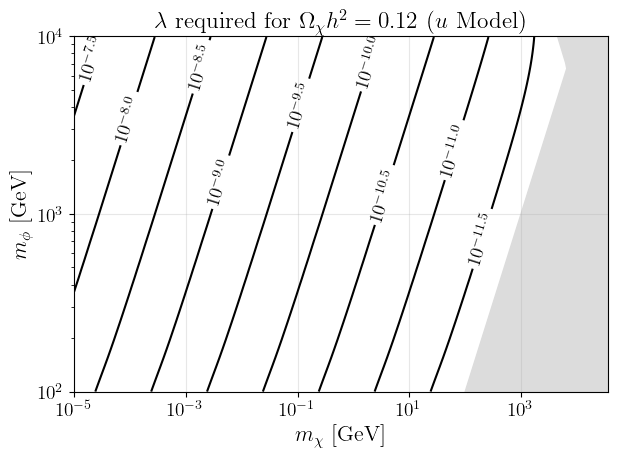

In [138]:
fig3 = figure()

xlim(1e-5, 3.6e4)
ylim(1e2, 1e4)

xscale("log")
yscale("log")
grid(alpha=0.3)

title(L"$\lambda$ required for $\Omega_\chi h^2 = 0.12$ ($u$ Model)")
xlabel(L"$m_\chi$ [GeV]")
ylabel(L"$m_\phi$ [GeV]")

levels = 10 .^reverse([-6, -6.5, -7, -7.5, -8, -8.5, -9, -9.5, -10, -10.5, -11, -11.5])
mphi_indices = mphis_for_plots .<= 1.0e4
#mchi_indices = mchis_for_plots .<= 5e2
C = contour(mchis_for_plots, mphis_for_plots[mphi_indices], lam2[mphi_indices,1:end], levels=levels, norm="log", colors="k")

formatter(l) = L"10^{ %$(log10(l)) }"

lvs = 10 .^reverse([-6, -6.5, -7, -7.5, -8, -8.5, -9, -9.5, -10, -10.5, -11, -11.5])
# lvs = levels

fill_betweenx(mphi_for_bound, mχ_upper, 5e4, color="gainsboro")#, alpha=0.2)

clabel(C, lvs[1:end-3], colors="black", fmt=formatter, use_clabeltext=true, 
        inline=true, inline_spacing=5, fontsize=14)#, manual=((3e-5, 5e3), (3e-4, 4e3),
        # (3e-3, 3e3), (3e-2, 3e3), (3e-1, 3e3), (3e0, 3e3), (3e1, 3e2)))

plotclose()
fig3.savefig(figdir * "uR_lambda_relic.pdf", bbox_inches="tight")
fig3

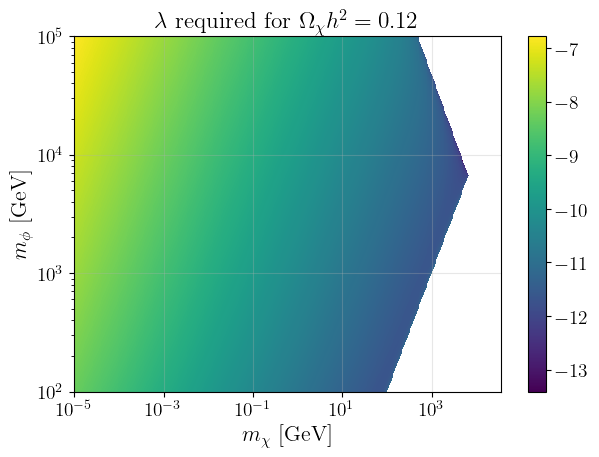

In [46]:
f6 = figure()

xlim(1e-5, 3.6e4)
ylim(1e2, 1e5)

xscale("log")
yscale("log")

grid(alpha=0.3)

title(L"$\lambda$ required for $\Omega_\chi h^2 = 0.12$")
xlabel(L"$m_\chi$ [GeV]")
ylabel(L"$m_\phi$ [GeV]")

# levels = 10 .^reverse([-6, -6.5, -7, -7.5, -8, -8.5, -9, -9.5, -10, -10.5, -11])
C = pcolormesh(mchis_for_plots, mphis_for_plots, log10.(lambdas_for_plots))
colorbar(C)

plotclose()
f6.savefig("pcolormesh_lambda_relic.pdf")
f6

In [ ]:
# made with the mphis_for_plots grid
mχ_prompt = readdlm("mchi_prompt_for_plot.csv", ',', Float16)[:,2]

500-element Vector{Float16}:
 6.0e-8
 6.0e-8
 6.0e-8
 6.0e-8
 6.0e-8
 6.0e-8
 6.0e-8
 6.0e-8
 6.0e-8
 1.0e-7
 ⋮
 0.0641
 0.0659
 0.06775
 0.06964
 0.0716
 0.0736
 0.0757
 0.0778
 0.07996

In [60]:
[ 0.0 for x in mchi_llplimit ]

50-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [70]:
mchi_llplimit = readdlm("mchi_llp_limit.csv", ',', Float16)[:,1]
mphi_llplimit = readdlm("mphi_llp_limit.csv", ',', Float16)[:,1]
;

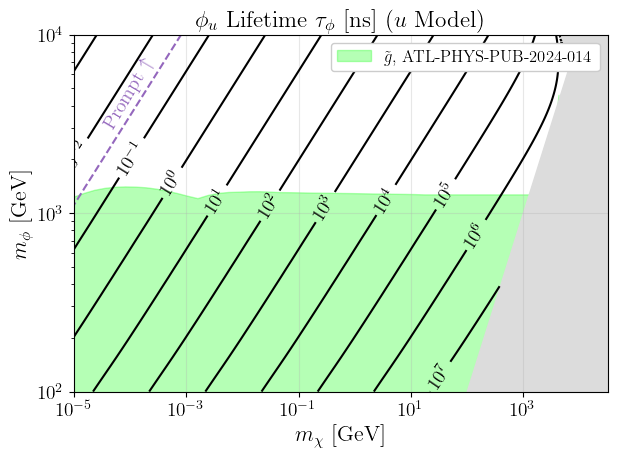

In [69]:
fig4 = figure()

xlim(1e-5, 3.2e4)
ylim(1e2, 1e4)

xscale("log")
yscale("log")

levels = 10.0 .^(-6:8)
C = contour(mchis_for_plots, mphis_for_plots, phi_lifetimes .* 1e9, levels=levels, norm="log", colors="black")

formatter(l) = L"10^{ %$(Int(log10(l))) }"

clabel(C, levels, colors="black", fmt=formatter, use_clabeltext=true, inline=true)


fill_between(mchi_llplimit, mphi_llplimit, [0.0 for _ in mphi_llplimit], color="xkcd:neon green", alpha=0.3, label=L"$\tilde{g}$, ATL-PHYS-PUB-2024-014")
fill_betweenx(mphi_for_bound, mχ_upper, 5e4, color="gainsboro")#, alpha=0.2)

# plot(mχ_prompt, Mphis_life)



plot(mχ_prompt, mphis_for_plots, c="tab:purple", linestyle="dashed")

text(3e-5, 3e3, L"Prompt $\uparrow$",rotation=59.5, c="tab:purple")

grid(alpha=0.3)

title(L"$\phi_u$ Lifetime $\tau_{\phi}$ [ns] ($u$ Model)")
#title(L"$\tau_{\phi}$ [ns], $\lambda = \lambda^*$")
xlabel(L"$m_\chi$ [GeV]")
ylabel(L"$m_\phi$ [GeV]")

legend(fontsize=12, framealpha=1, loc="upper right")

plotclose()
fig4.savefig(figdir * "uR_phi_lifetime.pdf")
fig4